# Setup

In [2]:
using DifferentialEquations, Plots, Turing, Interpolations, StatsPlots

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1278
┌ Info: Precompiling Interpolations [a98d9a8b-a2ab-59e6-89dd-64a1c18fca59]
└ @ Base loading.jl:1278
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278


# Three node network

In [3]:
phi(a::Number) = (exp(2*a)-1)/(exp(2*a)+1)

phi (generic function with 1 method)

In [22]:
function additive_noise!(du,u,p,t)
#     s,g,W,I,σ = p
    s,g,W,σ = p
    for i = 1:length(u)
        du[i] = σ #This value multiplies a random number drawn from N(0, dt) i.e. noise then scales with sampling rate and effective sd of noise will be e.g. 0.1*dt
    end
end

function network_model!(du,u,p,t)
#     s,g,W,I,σ = p
    s,g,W,σ = p
    for i=1:length(u)
#         du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u)) + I(t)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u))
    end
end

network_model! (generic function with 1 method)

In [23]:
num_nodes = 3
u0 = repeat([0.0], num_nodes)
Tmax = 100.0
tspan = (0,Tmax)

# s = 0.3
# g = 0.7
# W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]

ts = 1:1:Tmax
task = repeat([0.0], 100)
# task[4] = 1 #without impulse it'd be "resting state"
# I = LinearInterpolation(ts, task, extrapolation_bc = 0)
dt = 0.5
# σ = 0.1

# p = [s,g,W,I,σ]
# p = [0.3, 0.7, [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0], LinearInterpolation(ts, task, extrapolation_bc = 0), 0.1]
p = [0.3, 0.7, [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0], 0.1]

prob_sde = SDEProblem(network_model!,additive_noise!,u0,tspan,p)


SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0]

Note: If you don't turn off adaptive step size then the number of solved points will not be Tmax/dt. It will be determined as detailed [here](https://diffeq.sciml.ai/stable/basics/common_solver_opts/#Basic-Stepsize-Control)

In [6]:
# sol = solve(prob_sde, dt=dt, adaptive=false)

In [7]:
# plot(sol)

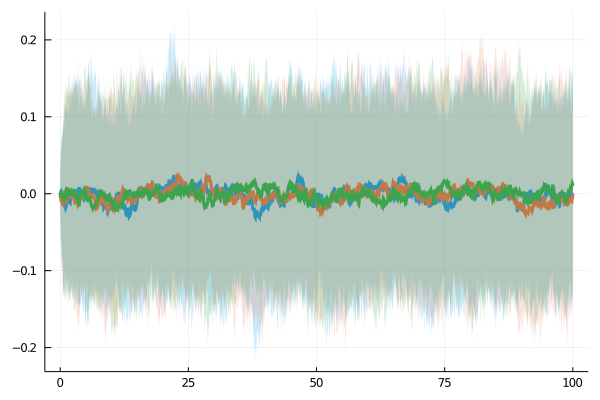

In [41]:
ensembleprob = EnsembleProblem(prob_sde)
# data = solve(ensembleprob, SOSRI(), trajectories=100, dt=dt, adaptive=false, saveat=dt)
data = solve(ensembleprob, SOSRI(), trajectories=100)
plot(EnsembleSummary(data))

In [42]:
Turing.setadbackend(:forwarddiff)
@model function fit_nmm(data, prob, ::Type{T} = Float64) where {T}
    ϕ ~ InverseGamma(2,3)
    σ ~ truncated(Normal(0.0,1.1),-3.0,3.0)
#     σ = 0.1
    s = 0.3
    g = 0.7
    W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]
#     ts = 1:1:Tmax
#     task = repeat([0.0], 100)
#     I = LinearInterpolation(ts, task, extrapolation_bc = 0)
#     p = [s,g,W,I,σ]
    p = [s,g,W,σ]
    prob = remake(prob, p=p, saveat=dt)
    predicted::Vector{Vector{T}} = solve(prob, SOSRI(), dt=dt, adaptive=false).u

#     if predicted.retcode != :Success
#         Turing.acclogp!(_varinfo, -Inf)
#     end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i],ϕ) #generate 3 points at a time for each node
        end
    end
end;

In [43]:
model = fit_nmm(data, prob_sde)

DynamicPPL.Model{var"#17#18",(:data, :prob, :T),(:T,),(),Tuple{EnsembleSolution{Float64,3,Array{RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Any,1},Nothing,SDEFunction{true,typeof(network_model!),typeof(additive_noise!),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(additive_noise!),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothin

In [45]:
@code_warntype model.f(
    Random.GLOBAL_RNG,
    model,
    Turing.VarInfo(model),
    Turing.SampleFromPrior(),
    Turing.DefaultContext(),
    model.args...,
)

Variables
  #self#::Core.Compiler.Const(var"#17#18"(), false)
  _rng::Core.Compiler.Const(Random._GLOBAL_RNG(), false)
  _model::DynamicPPL.Model{var"#17#18",(:data, :prob, :T),(:T,),(),Tuple{EnsembleSolution{Float64,3,Array{RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Any,1},Nothing,SDEFunction{true,typeof(network_model!),typeof(additive_noise!),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Not

In [44]:
chain = sample(model, NUTS(0.25), 100)

LoadError: TypeError: in typeassert, expected Float64, got a value of type ForwardDiff.Dual{Nothing,Float64,2}

In [ ]:
plot(chain)

In [15]:
typeof(u0)

Array{Float64,1}